San Franciso Flood Health Index Analysis

In [1]:
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [2]:
os.chdir(r"..\Data")
rawdf=pd.read_csv("sf_flood_cleaned.csv")

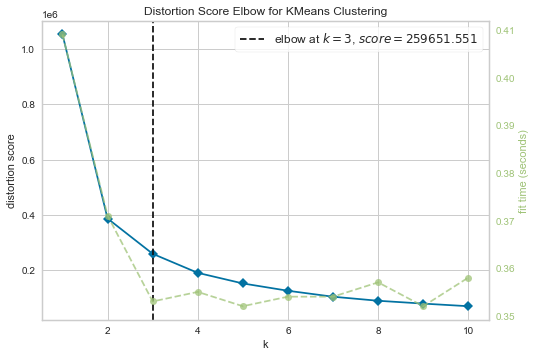

C:\Users\TwoYoung\AppData\Local\Temp/ipykernel_73752/2970099312.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Kmeans_df['K_means_labels']=labels


In [3]:
# K means clustering
X_Kmeans_df=rawdf[rawdf['FloodHealthIndex_Quintiles']>3]
X_Kmeans_df2=X_Kmeans_df.drop(['GEOID','FloodHealthIndex', 'FloodHealthIndex_Quintiles'],axis=1)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 11))
visualizer.fit(X_Kmeans_df2) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure
plt.show()

K = KMeans(n_clusters=3, random_state=0).fit(X_Kmeans_df2)
labels = K.labels_
X_Kmeans_df['K_means_labels']=labels

In [5]:
# Similarity inside each cluster (RSD method)
for i in range(0,3):
    print ("The three variables with the lowest standard deviation within cluster " + str(i+1))
    cluster_df=X_Kmeans_df[X_Kmeans_df["K_means_labels"]==i]
    cluster_df=cluster_df.drop(['GEOID',"K_means_labels","FloodHealthIndex","FloodHealthIndex_Quintiles"],axis=1)
    stdlist=(cluster_df.std()/cluster_df.mean()).sort_values()[0:3]
    print(stdlist)

The three variables with the lowest standard deviation within cluster 1
Education    0.171376
NonWhite     0.286607
LivAlone     0.437901
dtype: float64
The three variables with the lowest standard deviation within cluster 2
Education    0.095108
Asthma       0.214300
Poverty      0.249405
dtype: float64
The three variables with the lowest standard deviation within cluster 3
Education    0.157829
Elevation    0.282232
NonWhite     0.293587
dtype: float64


Fit a random forest model to use all variables to predict FHI
R-squared: 0.9878695545303472
MSE:  13.00468551645133
RMSE:  6.502342758225665


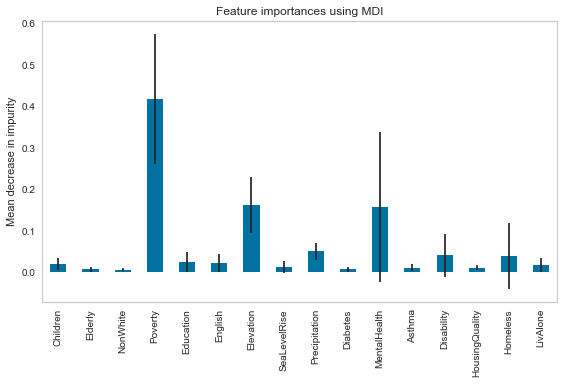

In [7]:
#randomforest
print ("Fit a random forest model to use all variables to predict FHI")
X_df=rawdf.drop(['GEOID','FloodHealthIndex', 'FloodHealthIndex_Quintiles'],axis=1)
y_df=rawdf['FloodHealthIndex']

X_train,X_test,y_train,y_test = train_test_split(X_df, y_df, random_state=1991,test_size=0.3)

feature_names = [f"feature {i}" for i in range(X_df.shape[1])]
forest = RandomForestRegressor(random_state=0)
forest.fit(X_train, y_train)

score = forest.score(X_train, y_train)
print("R-squared:", score) 

y_pred = forest.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_df.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.grid(False)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Fit a random forest model to use non-natural exposure risk variables to predict FHI
R-squared: 0.9724411300201653
MSE:  31.69455334757252
RMSE:  15.84727667378626


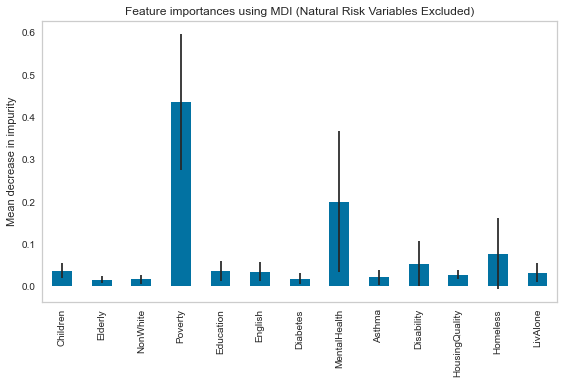

In [9]:

#randomforest (exclude natural risks)
print ("Fit a random forest model to use non-natural exposure risk variables to predict FHI")
X_df=rawdf.drop(['GEOID','FloodHealthIndex', 'FloodHealthIndex_Quintiles','Elevation','SeaLevelRise','Precipitation'],axis=1)
y_df=rawdf['FloodHealthIndex']

X_train,X_test,y_train,y_test = train_test_split(X_df, y_df, random_state=1991,test_size=0.3)

feature_names = [f"feature {i}" for i in range(X_df.shape[1])]
forest = RandomForestRegressor(random_state=0)
forest.fit(X_train, y_train)

score = forest.score(X_train, y_train)
print("R-squared:", score) 

y_pred = forest.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_df.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.grid(False)
ax.set_title("Feature importances using MDI (Natural Risk Variables Excluded)")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [10]:
#Correlation Between natural exposure risks and social-economic risks
corrdf=rawdf.drop(['GEOID','FloodHealthIndex', 'FloodHealthIndex_Quintiles'],axis=1)
corrlist=corrdf.corr()[['Elevation','SeaLevelRise','Precipitation']]
print(corrlist)

                Elevation  SeaLevelRise  Precipitation
Children         0.065316     -0.022899       0.046053
Elderly          0.133456     -0.096542      -0.077409
NonWhite        -0.134542      0.004747       0.081318
Poverty         -0.336851      0.031763       0.053936
Education        0.245580      0.015262      -0.071441
English         -0.137102     -0.072985       0.023682
Elevation        1.000000     -0.258823      -0.228096
SeaLevelRise    -0.258823      1.000000       0.077612
Precipitation   -0.228096      0.077612       1.000000
Diabetes        -0.318044      0.180725       0.100724
MentalHealth    -0.427889      0.031402       0.122155
Asthma          -0.373651     -0.000360       0.132927
Disability      -0.167537     -0.004167       0.009450
HousingQuality  -0.100058     -0.055827      -0.005631
Homeless        -0.448023      0.253721       0.040768
LivAlone        -0.237623      0.086178      -0.044279


In [12]:
#Fit a linear regression to analyze the contributors to homeless rate
from statsmodels.api import OLS
X_df=rawdf.drop(['GEOID','FloodHealthIndex', 'FloodHealthIndex_Quintiles', 'Homeless'],axis=1)
y_df=rawdf['Homeless']
OLS(y_df,X_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Homeless   R-squared (uncentered):                   0.721
Model:                            OLS   Adj. R-squared (uncentered):              0.713
Method:                 Least Squares   F-statistic:                              96.85
Date:                Sun, 09 Oct 2022   Prob (F-statistic):                   6.82e-145
Time:                        10:47:08   Log-Likelihood:                         -1609.4
No. Observations:                 578   AIC:                                      3249.
Df Residuals:                     563   BIC:                                      3314.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Children           3.5529      4.257      0.835      0.404      -4.808      11.914
Elderly          -21.7213      3.999     -5.431      0.000     -29.577     -13.866
NonWhite           6.3453      1.620      3.918      0.000       3.164       9.527
Poverty           -3.6523      2.362     -1.546      0.123      -8.291       0.987
Education         -2.0566      1.451     -1.418      0.157      -4.906       0.793
English           -3.4440      3.192     -1.079      0.281      -9.713       2.825
Elevation         -0.0122      0.002     -6.168      0.000      -0.016      -0.008
SeaLevelRise      19.2500      3.639      5.290      0.000      12.102      26.398
Precipitation    -34.5672     12.213     -2.830      0.005     -58.556     -10.578
Diabetes           0.0166      0.043      0.386      0.700      -0.068       0.101
MentalHealth      -0.1127      0.022     -5.216      0.000      -0.155      -0.070
Asthma             0.8637      0.106      8.147      0.000       0.655       1.072
Disability        33.2143      5.518      6.019      0.000      22.376      44.053
HousingQuality     0.0203      0.022      0.934      0.351      -0.022       0.063
LivAlone           8.6179      2.391      3.604      0.000       3.921      13.315
==============================================================================
Omnibus:                       96.946   Durbin-Watson:                   0.568
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.723
Skew:                           1.017   Prob(JB):                     1.03e-36
Kurtosis:                       4.657   Cond. No.                     1.21e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
#Home Price Correlation Test
homepricedf=pd.read_csv("sf_flood_homeprice.csv")
homepricedf=homepricedf.drop("GEOID_1",axis=1)
corrlist=homepricedf.corr()['Homeprice'].sort_values(ascending=False)
print(corrlist)

Homeprice           1.000000
Education           0.422538
Elevation           0.146365
Children            0.119885
HousingQuality      0.006047
LivAlone           -0.008320
SeaLevelRise       -0.041808
Elderly            -0.082608
Precipitation      -0.121629
MentalHealth       -0.241539
Homeless           -0.248961
Diabetes           -0.278461
Asthma             -0.289851
Disability         -0.303444
English            -0.430062
FloodHealthIndex   -0.453226
NonWhite           -0.473929
Poverty            -0.503403
Name: Homeprice, dtype: float64
